# Aggregating Daily Traffic Volume for the City of Chicago
Here, we will be importing traffic volume data for Chicago and aggregating it by Community Area

## Importing the necessary packages

In [1]:
library(sp)
library(rgdal)
library(rgeos)
library(DataCombine)
library(leaflet)
library(tmap)
library(dplyr)

rgdal: version: 1.2-16, (SVN revision 701)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.1.3, released 2017/20/01
 Path to GDAL shared files: /Library/Frameworks/R.framework/Versions/3.4/Resources/library/rgdal/gdal
 GDAL binary built with GEOS: FALSE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: /Library/Frameworks/R.framework/Versions/3.4/Resources/library/rgdal/proj
 Linking to sp version: 1.2-5 
rgeos version: 0.3-26, (SVN revision 560)
 GEOS runtime version: 3.6.1-CAPI-1.10.1 r0 
 Linking to sp version: 1.2-5 
 Polygon checking: TRUE 

Warning message:
“package ‘leaflet’ was built under R version 3.4.4”Warning message:
“package ‘tmap’ was built under R version 3.4.4”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:rgeos’:

    intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following object

## Importing the Traffic Data

The City of Chicago Open Data Portal provides information on Average Daily Traffic Counts, a "close approximation to the actual number of vehicles passing through a given location on an average weekday". The counts are done approximately once every ten years, but the most recent count was conducted in 2006. This count consists of point data for 1279 unique locations. The data is available for viewing and download [here](https://data.cityofchicago.org/Transportation/Average-Daily-Traffic-Counts/pfsx-4n4m/data). For the purposes of this data collection, we will download the Average Daily Traffic Count data was downloaded as a CSV (Average_Daily_Traffic_Counts.csv). 

In [2]:
Traffic <- read.csv("Average_Daily_Traffic_Counts.csv")

head(Traffic)

ID,Traffic.Volume.Count.Location..Address,Street,Date.of.Count,Total.Passing.Vehicle.Volume,Vehicle.Volume.By.Each.Direction.of.Traffic,Latitude,Longitude,Location
2,1708 West,71st Street,03/09/2006,14600,East Bound: 6900 / West Bound: 7700,41.76488,-87.66663,"(41.764877, -87.666635)"
3,1275 West,71st Street,02/28/2006,16500,East Bound: 7800 / West Bound: 8700,41.76501,-87.65707,"(41.765008, -87.657067)"
5,920 West,71st Street,02/28/2006,18200,East Bound: 8800 / West Bound: 9400,41.76515,-87.64775,"(41.765153, -87.647751)"
6,758 West,71st Street,02/28/2006,21600,East Bound: 10400 / West Bound: 11200,41.76520,-87.64437,"(41.765204, -87.644371)"
7,240 East,71st St,02/28/2006,18300,East Bound: 9000 / West Bound: 9300,41.76564,-87.61848,"(41.765644, -87.618476)"
9,2050 East,71st St,03/09/2006,8600,East Bound: 3600 / West Bound: 5000,41.76626,-87.57423,"(41.76626, -87.574226)"


As we can see, the traffic count dataset contains information on Address, Date, Total Volume, Directional Volume, and Coordinates

## Converting the Traffic Data to a Spatial Object

In [3]:
#Create a spatial object by assigning Lat/Lon coordinates to Traffic 
coordinates(Traffic) <- Traffic[,c("Longitude", "Latitude")]

In [4]:
#Set CRS of Traffic data to WSG84
proj4string(Traffic) <- CRS("+init=epsg:4326")

## Importing the Chicago Map with Community Area Boundaries Shapefile

The Chicago Open Data Portal provides a map of the current boundaries for each of the 77 Community Areas in city. This map can be downloaded [here](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6/data) as a Shapefile (Chi_Boundaries.shp) which we will subsequently import.

In [5]:
Chi.Map <- readOGR("Chi_Boundaries")

OGR data source with driver: ESRI Shapefile 
Source: "Chi_Boundaries", layer: "Chi_Boundaries"
with 77 features
It has 9 fields


In [6]:
#Transform projection of Chicago Map to WSG84 to match Traffic data
Chi.Map <- spTransform(Chi.Map ,CRS("+init=epsg:4326"))

## Spatially Overlaying Traffic Point Data on Community Area Polygons

In order to determine which Community Area (CA) each traffic node is in, we will overlay the point data on the map of the Chicago Community Areas 

In [7]:
#Returns a vector with length = # of Traffic points and community column with information on Community Area
PiP <- over(Traffic, Chi.Map)

In [8]:
#Create new dataframe with the variables that we will need (Lat/Lon, Volume, Community Area)
CA.Traffic <- data.frame(PiP$community, Traffic$Latitude, Traffic$Longitude, Traffic$Total.Passing.Vehicle.Volume)
#Rename columns for readability
colnames(CA.Traffic) <- c("Community_Area", "Latitude", "Longitude", "Traffic_Volume")


## Filling in Missing Information

We must first determine whether or not there are any elements of CA.Traffic for which the Community_Area variable is NA

In [9]:
summary(CA.Traffic)

         Community_Area    Latitude       Longitude      Traffic_Volume  
 LOOP           : 96    Min.   :41.65   Min.   :-87.85   Min.   :   700  
 NEAR WEST SIDE : 94    1st Qu.:41.78   1st Qu.:-87.71   1st Qu.: 11350  
 NEAR NORTH SIDE: 38    Median :41.87   Median :-87.66   Median : 17300  
 WEST TOWN      : 38    Mean   :41.85   Mean   :-87.67   Mean   : 19466  
 AUSTIN         : 36    3rd Qu.:41.91   3rd Qu.:-87.63   3rd Qu.: 24200  
 (Other)        :964    Max.   :42.02   Max.   :-87.53   Max.   :165200  
 NA's           : 13                                                     

In [10]:
#Create dataframe of all elements with NA values for Community Area
CA.NA <- CA.Traffic[which(is.na(CA.Traffic$Community_Area)),]

In [11]:
summary(CA.NA)

        Community_Area    Latitude       Longitude      Traffic_Volume 
 ALBANY PARK   : 0     Min.   :41.67   Min.   :-87.81   Min.   :15500  
 ARCHER HEIGHTS: 0     1st Qu.:41.73   1st Qu.:-87.80   1st Qu.:23600  
 ARMOUR SQUARE : 0     Median :41.90   Median :-87.77   Median :26100  
 ASHBURN       : 0     Mean   :41.85   Mean   :-87.75   Mean   :27077  
 AUBURN GRESHAM: 0     3rd Qu.:41.92   3rd Qu.:-87.72   3rd Qu.:29400  
 (Other)       : 0     Max.   :42.01   Max.   :-87.64   Max.   :41700  
 NA's          :13                                                     

From the summary, we see that there are 13 traffic nodes for which the match function was unable to assign a Community Area. These nodes are located just over the edge of the Community Area map and should, therefore, be included with the totals for the nearest community area. We must first create a spatial object from the NA dataframe.

In [12]:
#Assign coordinates and projection to NAs
coordinates(CA.NA) <- CA.NA[,c("Longitude", "Latitude")]
proj4string(CA.NA) <- CRS("+init=epsg:4326")

We need to now change the projection system of both the NAs and the Chicago base map to UTM so that we can properly use the rgeos function gDistance to determine the closest Community Area to a given point

In [13]:
#Change projections for both NAs and Community Area Map to UTM Zone 16
CA.NA <- spTransform(CA.NA,CRS("+init=epsg:26916"))
Chi.Map <- spTransform(Chi.Map ,CRS("+init=epsg:26916"))

We will now loop through the NAs and find the minimum value for gDistance between the point and a Community Area.

In [14]:
#Container for Nearest Community Areas
n <- length(CA.NA)
Nearest.CA <- character(n)

#Iterate through finding the nearest Community Area for each NA
for (i in seq_along(Nearest.CA)) {
  Nearest.CA[i] <- as.character(Chi.Map$community[which.min(gDistance(CA.NA[i,], Chi.Map, byid = TRUE))])
  print(Nearest.CA[i])
}

[1] "NORTH PARK"
[1] "AUSTIN"
[1] "MONTCLARE"
[1] "AUSTIN"
[1] "AUSTIN"
[1] "MOUNT GREENWOOD"
[1] "ASHBURN"
[1] "DUNNING"
[1] "EDISON PARK"
[1] "AUSTIN"
[1] "ASHBURN"
[1] "WEST PULLMAN"
[1] "MOUNT GREENWOOD"


Now that we have a vector of the correct Community Areas to assign each point, we need to replace the NAs in the original CA.Traffic dataframe with these vaues.

In [15]:
#Create counter variable for NA's
j = 1

#Check if value is NA and replace with nearest CA if it is
for(i in 1:nrow(CA.Traffic)) {
  if(is.na(CA.Traffic$Community_Area)[i]) {
    CA.Traffic$Community_Area[i] = Nearest.CA[j]
    j = j + 1
  }
}

In [16]:
#Revert CRS to WSG84 for Chicago Map
Chi.Map <- spTransform(Chi.Map ,CRS("+init=epsg:4326"))

## Aggregate Traffic by Community Area

Now that we have determined the Community Area for each traffic point, it is time to calculate the total traffic volume for each Community Area

In [17]:
#Group Traffic data by Community Area and total up volume for each one
CA.Agg <- CA.Traffic %>% 
  group_by(Community_Area) %>%
  summarize(sum(Traffic_Volume))

colnames(CA.Agg) <- c("community", "Traffic_Volume")

nrow(CA.Agg)

[1] 76

As stated above, Chicago has 77 Community Areas, but only 76 are in the new dataframe. It appears that the Community Area of Burnside does not show up because no traffic points are located there. We will manually add it in and assign it a volume of 0

In [18]:
Burnside <- c("BURNSIDE", 0)
CA.Agg <- InsertRow(CA.Agg, Burnside, RowNum = 13)

Now that we have our Community Area aggregates, we want to add the traffic volume to our Spatial Polygon map of the Communtiy Areas so that it is attached to the geographical information therein contained

In [19]:
#first convert traffic volume to integer
CA.Agg$Traffic_Volume <- as.integer(CA.Agg$Traffic_Volume)

#Join the two dataframes
Chi.Map@data <- left_join(Chi.Map@data, CA.Agg)

Joining, by = "community"


In order to make sure that the join had the desired effect, let's create a quick choropleth map of the traffic volume aggregates by Community Area

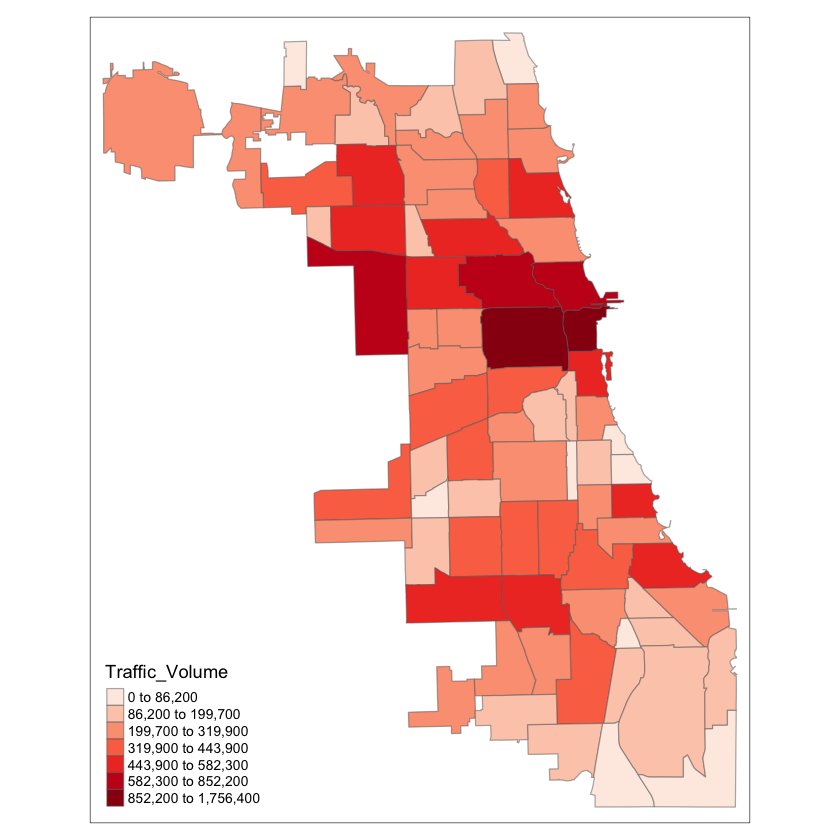

In [20]:
tm_shape(Chi.Map) +
  tm_fill("Traffic_Volume", style = "jenks", n = 7, palette = "Reds") + 
  tm_borders(alpha = 0.5)

## Exporting the Data

We want to export two shapefiles: 
1. The traffic volume point data with the additional information of the Community Area of each point
2. The Chicago Community Area map with the additional information of the aggregate traffic volume by Community Area

First, we must make a spatial dataframe out of CA.Traffic, then we can create the shapefiles 

In [21]:
#Turn CA.Traffic into spatial points data frame
coordinates(CA.Traffic) <- CA.Traffic[,c("Longitude", "Latitude")]
proj4string(CA.Traffic) <- CRS("+init=epsg:4326")
CA.Traffic <- spTransform(CA.Traffic,CRS("+init=epsg:4326"))

#Create the two shapefiles
writeOGR(CA.Traffic,".","Traffic_Points_with_Community_Areas",driver="ESRI Shapefile")
writeOGR(Chi.Map,".","Community_Areas_with_Traffic_Volumes",driver="ESRI Shapefile")

Warning message in writeOGR(CA.Traffic, ".", "Traffic_Points_with_Community_Areas", :
“Field names abbreviated for ESRI Shapefile driver”Warning message in writeOGR(Chi.Map, ".", "Community_Areas_with_Traffic_Volumes", :
“Field names abbreviated for ESRI Shapefile driver”